<h1>02 Einführung in LLMs und Prompt Engineering</h1>


💡 **Bitte beachten**: Wir möchten einen Grafikprozessor in Google Colab verwenden. Bitte ändern Sie diesen wenn nötig auf GPU T4 oder ähnliche.

**Verbinden > Laufzeittypändern > Hardware Beschleuniger > GPU > GPU type > T4**.

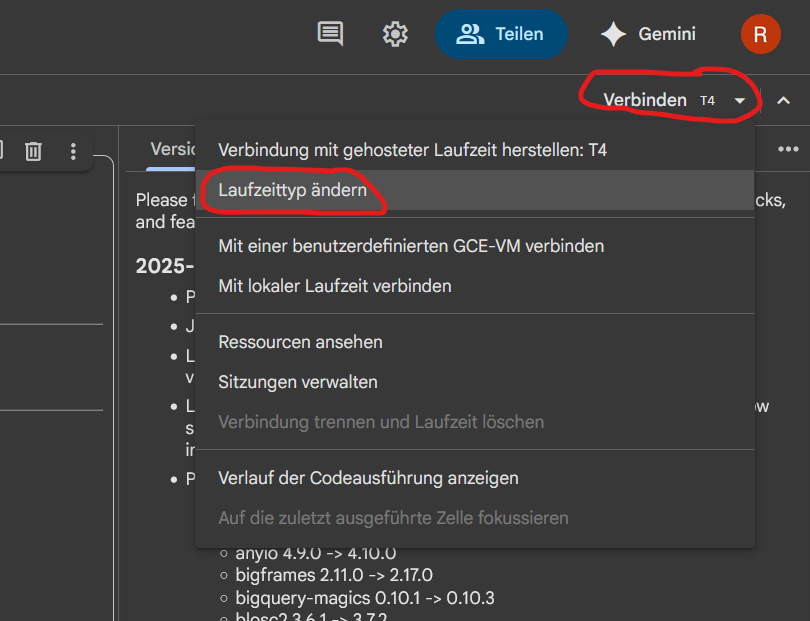

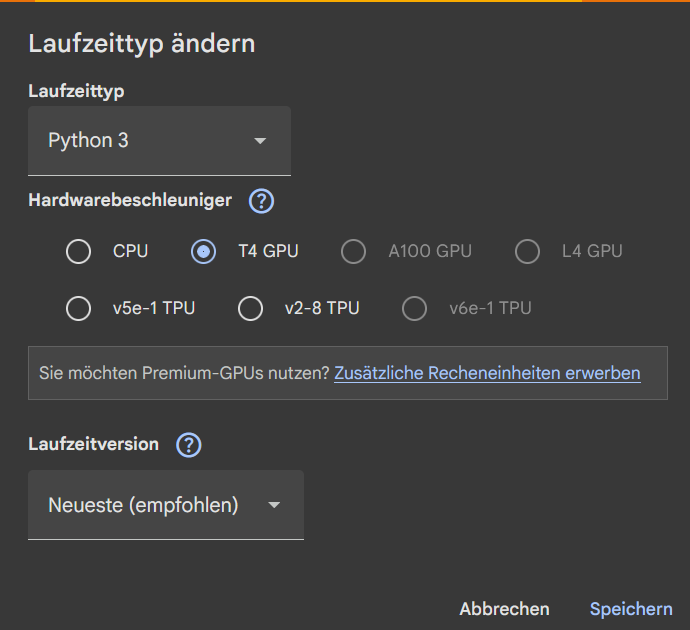

Bitte führen Sie nachfolgende Zelle aus um notwendige Installationen in Umgebung zu installieren.

Zellen können über den Play-Button ausgeführt werden.

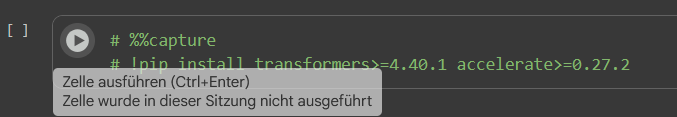

In [ ]:
%%capture
!pip install langchain>=0.1.17 openai>=1.13.3 langchain_openai>=0.1.6 transformers>=4.40.1 datasets>=2.18.0 accelerate>=0.27.2 sentence-transformers>=2.5.1 duckduckgo-search>=5.2.2
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" pip install llama-cpp-python

## Vorbereitung des Chat Models 
LLM-Model: Phi-3-mini-4k-instruct
E-Techniker: Noch fehlen Ihnen ggf. die Grundlagen um diesen Code zu verstehen. Das wird sich im Laufe des Jahres ändern.

Zur Erklärung: Wir erzeugen ihr jeweils ein Objekt für unsere Daten ("Model") und unseren Tokenizer (encoder). Was ein Tokenizer macht, lernen wir in der nächsten Stunde.
Die Objekte werden zum einfacheren Handling in einem Pipline gepackt. Diese führt bei Objekte in Kombination aus. (So als ob Sie mehrere Schleifen mit einander kombinieren)

- Für uns entscheiden ist der Parameter **max_new_tokens**. Über diesen können sie einstellen, wie viele Wörter ihre Output haben soll.
- Über **do_sample** können Sie beeinflussen ob auch kreative Anworten möglich sind. Bei False ist dies nicht der Fall. 
- Mit dem Parameter **return_full_text** können Sie die Ausgabe um überflüssige Wörter kürzen.

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# Lade Modell und Tokenizer
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=False,
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Erstelle die Pipeline
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=False,
    max_new_tokens=500,
    do_sample=False,
)

Lassen Sie uns einen Prompt versuchen. Wir definieren eine Liste mit einem Dictionary als Inhalt. Anschließend übergeben wir diese unser Pipline und erhalten den Output. Wir greifen nur auf bestimmte Werte des Output zu und geben diesen in der Konsole aus.

In [ ]:
# Prompt
messages = [
    {"role": "user", "content": "Create a funny joke about chickens."}
]

# Erzeuge den Output
output = pipe(messages)
print(output[0]["generated_text"])

 Why don't chickens like to go to the gym? Because they can't crack the egg-sistence of it!


### Aufgabe 1: 
Versuchen Sie es selbst einmal. Ändern Sie die Message und erzeugen Sie einen eigenen Output! Ist dieser bei Ihnen witzig? (Also ich hab schon bessere gehört)




Why did Darth Vader refuse to play hide and seek with Luke Skywalker?

Because every time he tried to hide, he ended up in a dark place, and he couldn't find the light switch!


### Aufgabe 2: 
Was passiert, wenn Sie die Parameter max_new_tokens, return_full_text oder do_sample verändern? Probieren Sie es aus. Stellen Sie nach dieser Übung die Parameter wieder auf die ursprüngliche Werte ein:

return_full_text=False,
max_new_tokens=500,
do_sample=False,

### Aufgabe 3: (Für schnelle)
Können Sie die Message auch über die Konsole einlesen?


--------------------------------------------------------------
Ein weiterer nützlicher Parameter ist **temperature**. Möchten Sie möglichst deterministische Outputs erhalten, sollte sich dieser Wert 0 an nähern. Bei wechselnden Outputs sollte dieser näher bei 1 liegen.

### Aufgabe 4:
Probieren sie es aus verändern sie den Parameter und führen sie die Zelle mehrfach aus! (Der Parameter wird der pipe übergeben)

ursprünglicher Wert: temperature=1

------
Mi dem Parameter **top_p** können sie ebenfalls die Zufälligkeit und Kreativität beeinflussen. Der Parameter erzeugt einen dynamischen Pool aus Tokens aus dem die Lösung generiert wird. Ein Wert nahe 1 steht für Kreativität und Zufälligkeit. Im Vergleich dazu sind niedrige Werte mehr fokusierend und sachlich.

### Aufgabe 5:
Probieren Sie es wieder aus! (Der Parameter wird wieder der Pipe übergeben)

ursprünglicher Wert: top_p=1

# **Prompt Engineering**


In [ ]:
# Text to summarize which we stole from https://jalammar.github.io/illustrated-transformer/ ;)
text = """In the previous post, we looked at Attention – a ubiquitous method in modern deep learning models. Attention is a concept that helped improve the performance of neural machine translation applications. In this post, we will look at The Transformer – a model that uses attention to boost the speed with which these models can be trained. The Transformer outperforms the Google Neural Machine Translation model in specific tasks. The biggest benefit, however, comes from how The Transformer lends itself to parallelization. It is in fact Google Cloud’s recommendation to use The Transformer as a reference model to use their Cloud TPU offering. So let’s try to break the model apart and look at how it functions.
The Transformer was proposed in the paper Attention is All You Need. A TensorFlow implementation of it is available as a part of the Tensor2Tensor package. Harvard’s NLP group created a guide annotating the paper with PyTorch implementation. In this post, we will attempt to oversimplify things a bit and introduce the concepts one by one to hopefully make it easier to understand to people without in-depth knowledge of the subject matter.
Let’s begin by looking at the model as a single black box. In a machine translation application, it would take a sentence in one language, and output its translation in another.
Popping open that Optimus Prime goodness, we see an encoding component, a decoding component, and connections between them.
The encoding component is a stack of encoders (the paper stacks six of them on top of each other – there’s nothing magical about the number six, one can definitely experiment with other arrangements). The decoding component is a stack of decoders of the same number.
The encoders are all identical in structure (yet they do not share weights). Each one is broken down into two sub-layers:
The encoder’s inputs first flow through a self-attention layer – a layer that helps the encoder look at other words in the input sentence as it encodes a specific word. We’ll look closer at self-attention later in the post.
The outputs of the self-attention layer are fed to a feed-forward neural network. The exact same feed-forward network is independently applied to each position.
The decoder has both those layers, but between them is an attention layer that helps the decoder focus on relevant parts of the input sentence (similar what attention does in seq2seq models).
Now that we’ve seen the major components of the model, let’s start to look at the various vectors/tensors and how they flow between these components to turn the input of a trained model into an output.
As is the case in NLP applications in general, we begin by turning each input word into a vector using an embedding algorithm.
Each word is embedded into a vector of size 512. We'll represent those vectors with these simple boxes.
The embedding only happens in the bottom-most encoder. The abstraction that is common to all the encoders is that they receive a list of vectors each of the size 512 – In the bottom encoder that would be the word embeddings, but in other encoders, it would be the output of the encoder that’s directly below. The size of this list is hyperparameter we can set – basically it would be the length of the longest sentence in our training dataset.
After embedding the words in our input sequence, each of them flows through each of the two layers of the encoder.
Here we begin to see one key property of the Transformer, which is that the word in each position flows through its own path in the encoder. There are dependencies between these paths in the self-attention layer. The feed-forward layer does not have those dependencies, however, and thus the various paths can be executed in parallel while flowing through the feed-forward layer.
Next, we’ll switch up the example to a shorter sentence and we’ll look at what happens in each sub-layer of the encoder.
Now We’re Encoding!
As we’ve mentioned already, an encoder receives a list of vectors as input. It processes this list by passing these vectors into a ‘self-attention’ layer, then into a feed-forward neural network, then sends out the output upwards to the next encoder.
"""

# Prompt Bestandteile
persona = "You are an expert in Large Language models. You excel at breaking down complex papers into digestible summaries.\n"
instruction = "Summarize the key findings of the paper provided.\n"
context = "Your summary should extract the most crucial points that can help researchers quickly understand the most vital information of the paper.\n"
data_format = "Create a bullet-point summary that outlines the method. Follow this up with a concise paragraph that encapsulates the main results.\n"
audience = "The summary is designed for busy researchers that quickly need to grasp the newest trends in Large Language Models.\n"
tone = "The tone should be professional and clear.\n"
text = "MY TEXT TO SUMMARIZE"  # Ersetzen Sie dies durch Ihren eigenen Text
data = f"Text to summarize: {text}"

# Hier wird der komplette Prompt zusammengesetzt
query = persona + instruction + context + data_format + audience + tone + data

In [ ]:
messages = [
    {"role": "user", "content": query}
]
# Über den Aufruf von apply_chat_template wird der Prompt in das für das Modell benötigte Format gebracht. 
# Diesen können wir uns auch ausgeben lassen.
print(tokenizer.apply_chat_template(messages, tokenize=False))

<s><|user|>
You are an expert in Large Language models. You excel at breaking down complex papers into digestible summaries.
Summarize the key findings of the paper provided.
Your summary should extract the most crucial points that can help researchers quickly understand the most vital information of the paper.
Create a bullet-point summary that outlines the method. Follow this up with a concise paragraph that encapsulates the main results.
The summary is designed for busy researchers that quickly need to grasp the newest trends in Large Language Models.
The tone should be professional and clear.
Text to summarize: MY TEXT TO SUMMARIZE<|end|>
<|assistant|>



In [ ]:
# So würde der Ouput zum obigen Prompt aussehen
outputs = pipe(messages)
print(outputs[0]["generated_text"])

 Key Findings:

- The Transformer model utilizes attention mechanisms to improve the speed and performance of deep learning models, particularly in neural machine translation tasks.
- It outperforms the Google Neural Machine Translation model in specific tasks and is recommended by Google Cloud for their Cloud TPU offering.
- The Transformer model consists of an encoding component and a decoding component, both composed of stacks of identical encoders and decoders.
- The encoders use self-attention layers to process input sequences, while the decoders incorporate attention layers to focus on relevant parts of the input.
- The model employs embedding algorithms to convert input words into vectors of size 512, which are then processed through the encoder's layers.
- The Transformer model's architecture allows for parallelization, enabling faster training and improved performance.

Summary:

- The Transformer model, introduced in the paper "Attention is All You Need," revolutionizes deep 

### Aufgabe 6:
Nun sind Sie an der Reihe. Erzeugen Sie einen komplizierten Prompt. Vielleicht zum Thema StarWars, Fluch der Karibik, LLMs oder ähnlichem. 

Aber **Achtung**. Google Colab ist kostenlos. Dafür sammelt Google Daten wie Eingabeaufforderungen, zugehörigen Code, generierte Ausgabe, Informationen zur Verwendung zugehöriger Funktionen und Ihr Feedback.